# Exploratory Data Analysis

## Description

Although the primary objective of this project is to **predict the
tips** that taxi drivers receive from passengers, it’s crucial to have a
comprehensive understanding of the data to **avoid drawing incorrect
conclusions**. To achieve this, we will perform the following steps:

1.  **Explore the distribution of each individual variable** to
    understand what is typical or atypical and identify data quality
    issues.
2.  **Validate domain knowledge assumptions** to uncover data quality
    problems or correct erroneous assumptions that could potentially
    affect our final conclusions.
3.  **Create new features** based on domain knowledge to enhance the
    likelihood of discovering valuable insights.
4.  **Impute missing values** to prevent introducing bias.
5.  **Use PCA and EFA** to understand the correlation between features.

## Setting Up The Environment

1.  Loading main packages

In [ ]:
library(here)
library(data.table)
library(lubridate)
library(ggplot2)
library(scales)
library(patchwork)
theme_set(theme_light())

source(here("R/02-custom-functions.R"))

1.  Importing data from January to March as our training data with
    **56,853,541 rows** corresponding to **10 GB**.

In [ ]:
TripDataTrain <- fst::read_fst(
  path = here("data/TripDataTrain.fst"),
  as.data.table = TRUE
)

TripDataDim <- dim(TripDataTrain)
comma(TripDataDim)

[1] "56,853,541" "24"        

1.  Downsampling the data to **17,000,000 rows** to solve memory
    limitation problems, but keeping a **representative sample** of the
    population.

In [ ]:
set.seed(20230922)
TripDataTrain <- TripDataTrain[sample.int(TripDataDim[1L],17e6)]

TripDataDim <- dim(TripDataTrain)
comma(TripDataDim)

[1] "17,000,000" "24"        

1.  Decoding data based on dictionary information.

In [ ]:
TripDataTrain <- decode_cols(
  trip_table = TripDataTrain,
  zone_path = here("data/taxi_zone_lookup.csv")
)

## 1. Variable Distribution

To avoid spending too much time on this step, use the same visualization
based on the variable’s type.

### Categorical Variables Distribution

In [ ]:
cat_vars <- TripDataTrain[, names(.SD), .SDcols = is.character]

for(cat_i in cat_vars){
  TripDataTrain[, .(count = .N), 
                by = cat_i
  ][, pct_count := round(count/sum(count)*100, 2)
  ][order(-count)] |>
  print()
}

   hvfhs_license_num    count pct_count
1:              Uber 12383090     72.84
2:              Lyft  4616910     27.16
    dispatching_base_num    count pct_count
 1:               B03404 12379708     72.82
 2:               B03406  4616910     27.16
 3:               B02764     1207      0.01
 4:               B02870      435      0.00
 5:               B02872      260      0.00
 6:               B02835      239      0.00
 7:               B02871      186      0.00
 8:               B02889      159      0.00
 9:               B02869      154      0.00
10:               B02887      148      0.00
11:               B02882      117      0.00
12:               B02765      113      0.00
13:               B02877       92      0.00
14:               B02876       86      0.00
15:               B02879       80      0.00
16:               B02864       57      0.00
17:               B02884       39      0.00
18:               B02875        5      0.00
19:               B02865        4      0.00


#### Findings

By counting the rows by category for each row, we found that:

-   We can **remove** the `dispatching_base_num` and
    `originating_base_num` as their information is very close to the
    `hvfhs_license_num`, and their other values only represent **0.02%**
    of the rows.

-   Based on `shared_request_flag` and `shared_match_flag`, we know that
    most of the passengers **agree to share the ride** even if other
    passengers booked separately.

-   Based on `access_a_ride_flag`, we know that most of the **trips were
    administered by MTA**. We also found that the field is missing the
    “Y” flag.

-   Based on `wav_request_flag` and `wav_match_flag`, we know that only
    **0.16%** of trips requested a wheelchair-accessible vehicle, but
    **6.84%** of trips had that capacity, which is really good news.

-   In the `PU_Borough` and `DO_Borough` columns, very few trips pass
    through “Staten Island”, “Unknown”, or “EWR”, so we will consolidate
    them as “Other”.

-   `PU_Zone` and `DO_Zone` have too many categories, and we don’t need
    them for this process.

-   As “EWR” represents the **Newark Liberty International Airport** and
    represents very few trips, we can consolidate this category to the
    more general one “Airports” for the `PU_service_zone` and
    `DO_service_zone` columns.

### Numerical Variables Distribution

To validate numeric variables we are potting at original and logarithmic
scale.

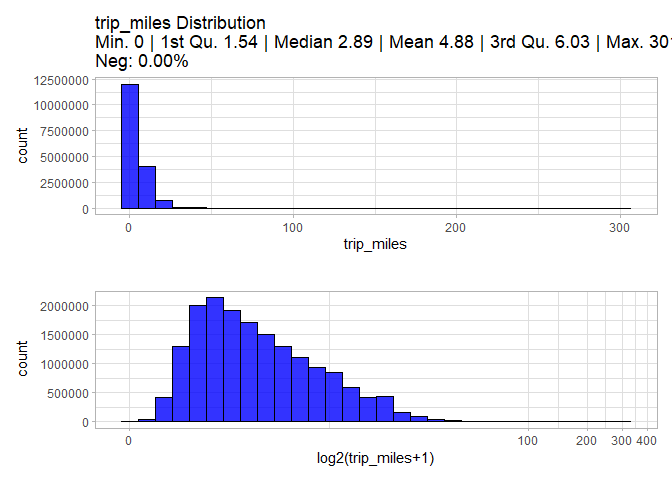

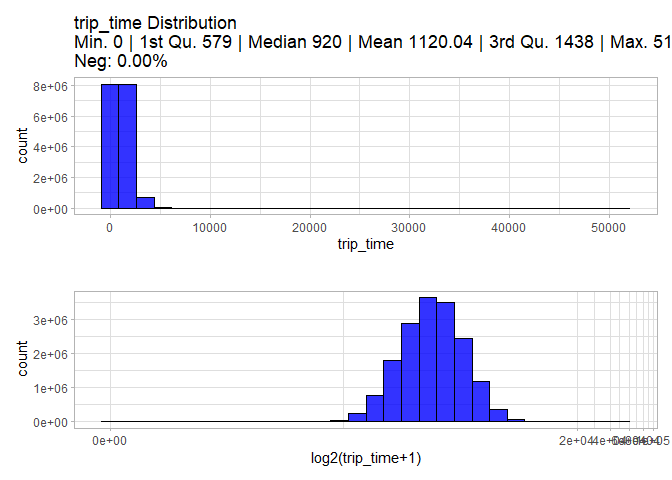

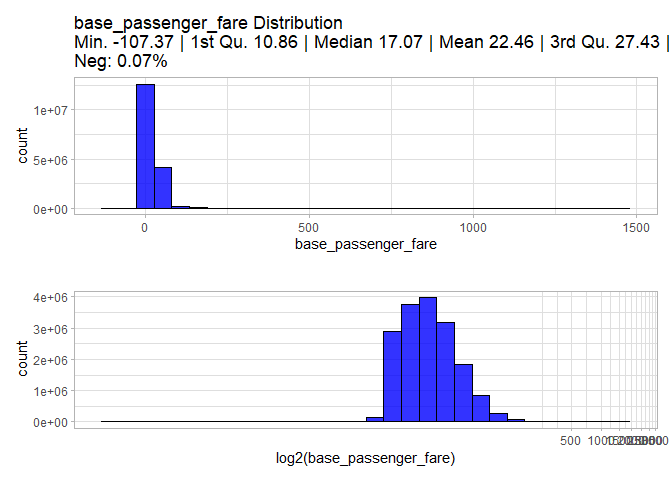

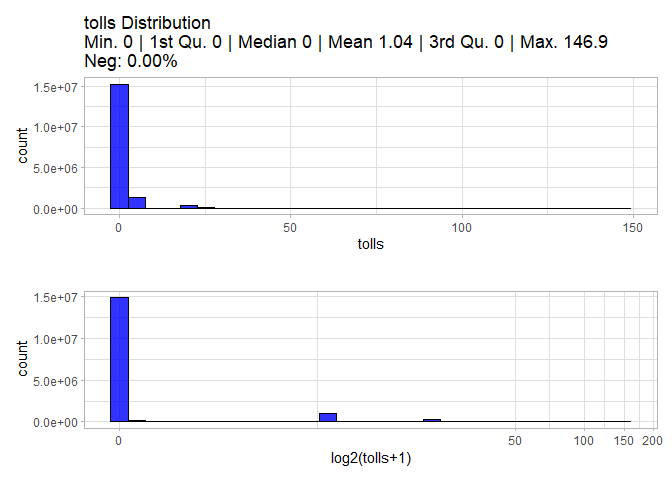

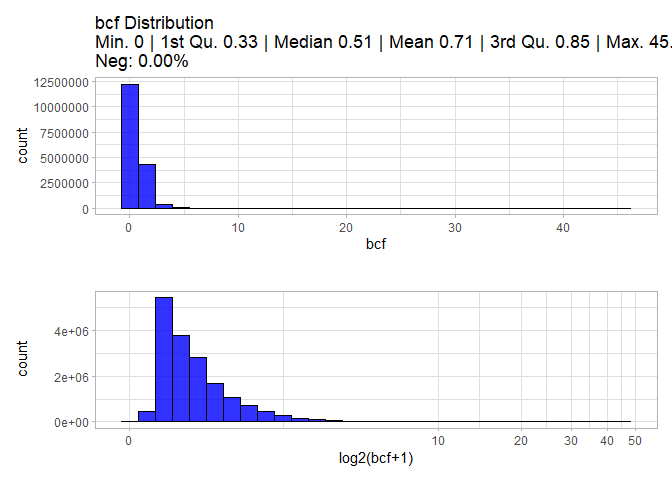

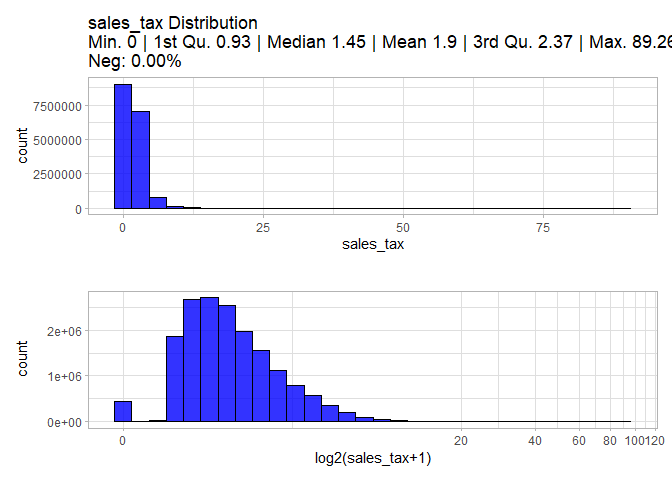

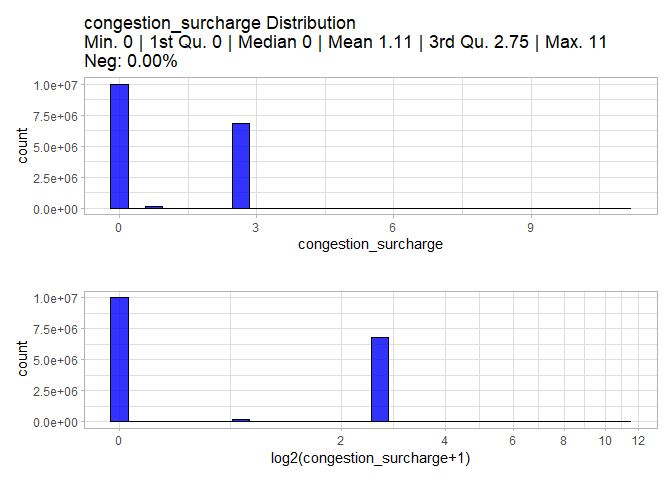

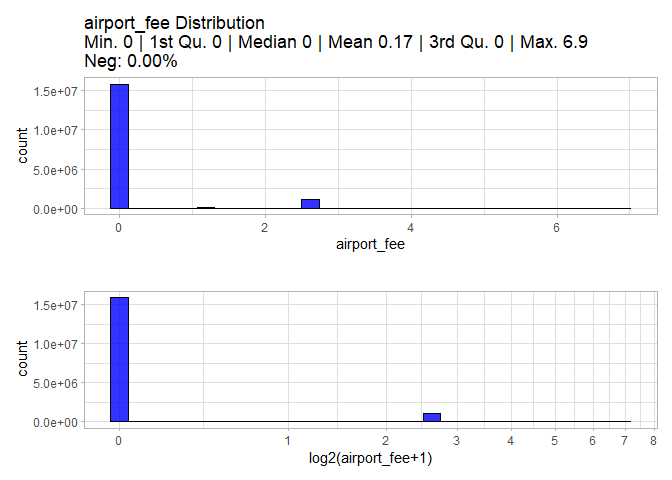

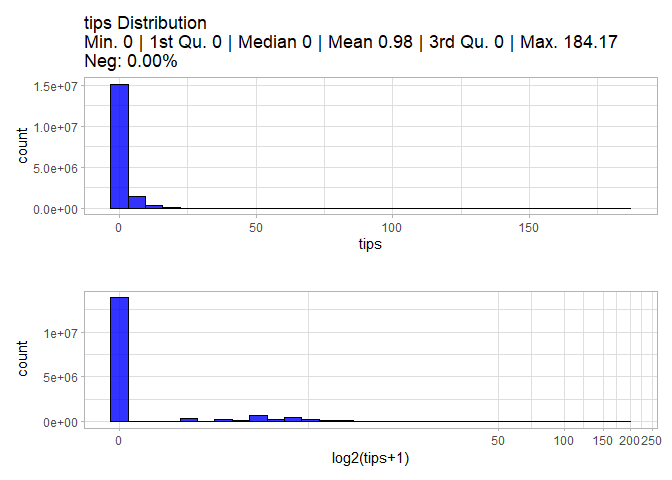

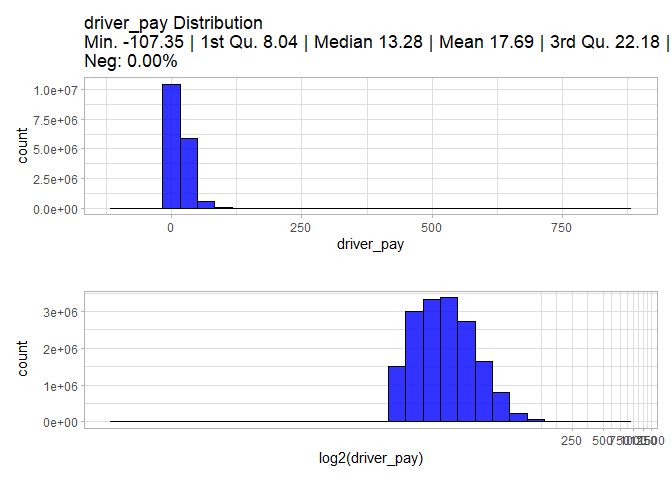

In [ ]:
num_vars <- TripDataTrain[, names(.SD), .SDcols = is.numeric]

for(num_i in num_vars){
  
 print(custom_histogram(TripDataTrain, num_i))

}

#### Findings

After exploring the histogram of each variable, we found that:

-   **3,045** trips have 0 miles, which doesn’t make much sense unless
    the that the trip started and ended at the same location, otherwise
    these values should be label as `NA`.

### Datetime Variables Distribution

To validate numeric variables we are potting at normal and logarithmic
scale.

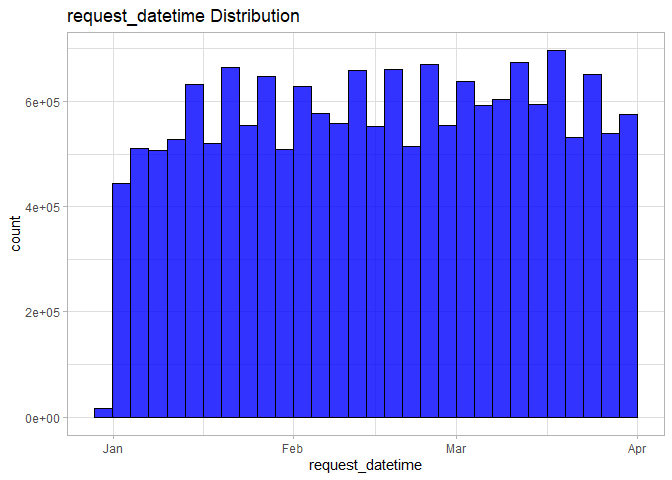

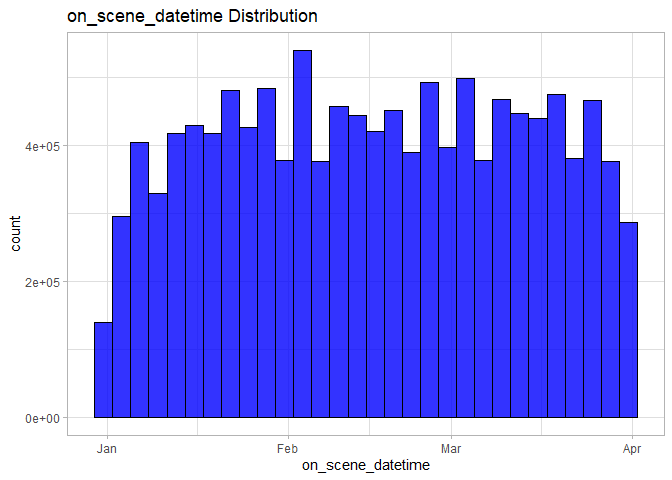

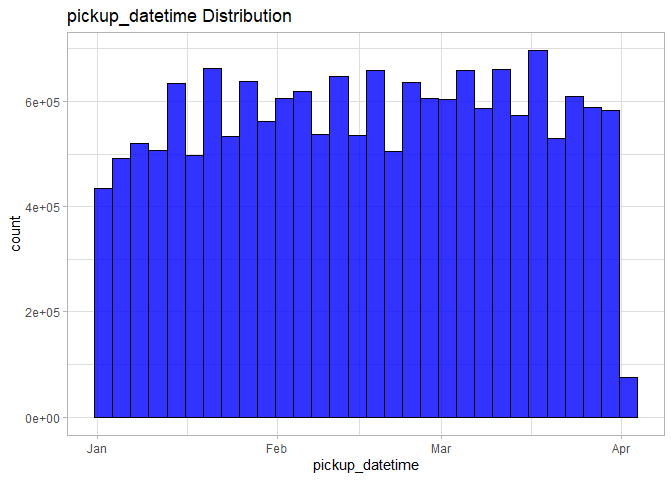

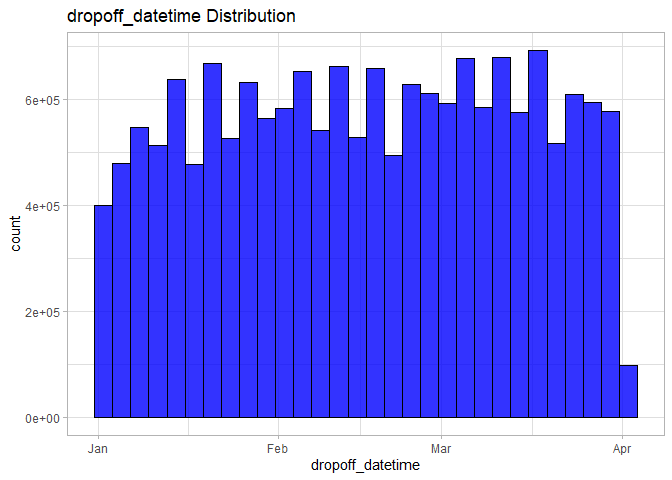

In [ ]:
date_vars <- TripDataTrain[, names(.SD), .SDcols = is.POSIXct]

for(date_i in date_vars){
  
  date_hist <-
    ggplot(TripDataTrain, aes(get(date_i)))+
    geom_histogram(fill = "blue",
                   color = "black",
                   alpha = 0.8,
                   bins = 30)+
    labs(title = paste0(date_i, " Distribution"),
         x = date_i)
  
  print(date_hist)
}

## Domain Knowledge Validation

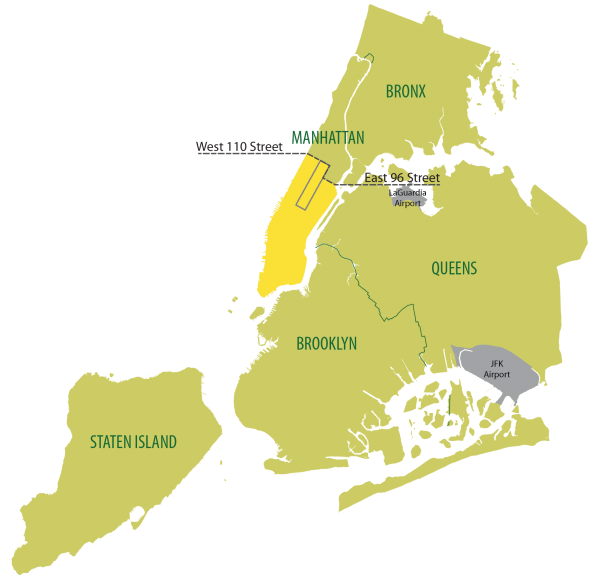

In [ ]:
TripDataTrain[trip_miles == 0,
              .N,
              keyby = .(same_service_zone = PU_service_zone == DO_service_zone,
                        same_Borough = PU_Borough == DO_Borough,
                        same_Zone = PU_Zone == DO_Zone)]

   same_service_zone same_Borough same_Zone    N
1:             FALSE        FALSE     FALSE   29
2:             FALSE         TRUE     FALSE   13
3:              TRUE        FALSE     FALSE   13
4:              TRUE         TRUE     FALSE  138
5:              TRUE         TRUE      TRUE 2852

    PU_Borough                      PU_Zone PU_service_zone    DO_Borough
 1:     Queens                  JFK Airport        Airports        Queens
 2:   Brooklyn                  Fort Greene       Boro Zone     Manhattan
 3:  Manhattan            East Harlem South       Boro Zone     Manhattan
 4:  Manhattan     Washington Heights North       Boro Zone         Bronx
 5:  Manhattan         Central Harlem North       Boro Zone      Brooklyn
 6:  Manhattan    West Chelsea/Hudson Yards     Yellow Zone     Manhattan
 7:   Brooklyn                    Bay Ridge       Boro Zone        Queens
 8:  Manhattan               Central Harlem       Boro Zone     Manhattan
 9:  Manhattan            East Harlem South       Boro Zone     Manhattan
10:     Queens             South Ozone Park       Boro Zone        Queens
11:     Queens             South Ozone Park       Boro Zone        Queens
12:     Queens             South Ozone Park       Boro Zone        Queens
13:  Manhattan            East Harlem 

In [ ]:
library(leaflet)
library(here)

# Define the locations
data <- data.frame(adress = c("JFK Airport, Queens, NY, US",
                              "Briarwood/Jamaica Hills, Queens, NY, US"))


geo2 <- tidygeocoder::geocode(data, address = "adress", method = "arcgis")

# Calculate the distance
dist2 <- osrm::osrmRoute(
  src = geo2[1,c("long","lat")],
  dst = geo2[2,c("long","lat")],
  overview = "full"
)

# Print the distance in miles
print(dist2$distance * 0.621371)

[1] 7.939319